# Geometric Modeling of EHT Data (Julia_1.8.3 버전)

In [1]:
versioninfo()

Julia Version 1.8.3
Commit 0434deb161e (2022-11-14 20:14 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 20 × 12th Gen Intel(R) Core(TM) i7-12700F
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, goldmont)
  Threads: 1 on 20 virtual cores
Environment:
  LD_LIBRARY_PATH = :/usr/local/cuda-11.7/lib64


## 환경 설정 

In [2]:
cd("/home/bread/astro/Comrade.jl/examples/GeometricModeling_1.8.3")

In [3]:
pwd()

"/home/bread/astro/Comrade.jl/examples/GeometricModeling_1.8.3"

In [4]:
import Pkg #hide
__DIR = @__DIR__ #hide

"/home/bread/astro/Comrade.jl/examples/GeometricModeling_1.8.3"

In [5]:
pkg_io = open(joinpath(__DIR, "pkg.log"), "w") #hide


IOStream(<file /home/bread/astro/Comrade.jl/examples/GeometricModeling_1.8.3/pkg.log>)

In [6]:
Pkg.activate(__DIR; io=pkg_io) #hide


In [7]:
Pkg.develop(; path=joinpath(__DIR, "..", ".."), io=pkg_io) #hide


In [8]:
Pkg.instantiate(; io=pkg_io) #hide


In [9]:
Pkg.precompile(; io=pkg_io) #hide


In [10]:
close(pkg_io) #hide
ENV["GKSwstype"] = "nul" #hide

"nul"

In [ ]:
# using Pkg
# Pkg.activate("/home/bread/astro/Comrade.jl/examples/GeometricModeling")
# Pkg.instantiate()

In [ ]:
# 주의! PyCall과 Pyehtim 충돌로 kernel이 죽는 상황이 발생할 수 있음

# using PyCall

In [ ]:
# PyCall.python

In [ ]:
# ENV["PYTHON"] = "/home/bread/anaconda3/envs/astroenv/bin/python"

In [ ]:
# using Pkg
# Pkg.build("PyCall")

In [ ]:
# 변경된 경로 확인

# PyCall.python

## 데이터 로딩

In [12]:
using Pyehtim

In [13]:
using Comrade

┌ Info: Precompiling Comrade [99d987ce-9a1e-4df8-bc0b-1ea019aa547b]
└ @ Base loading.jl:1664


In [14]:
using StableRNGs
rng = StableRNG(42)

StableRNGs.LehmerRNG(state=0x00000000000000000000000000000055)

In [15]:
obs = ehtim.obsdata.load_uvfits(joinpath(__DIR, 
        "../Data/SR1_M87_2017_096_lo_hops_netcal_StokesI.uvfits"))

Python: <ehtim.obsdata.Obsdata object at 0x7ff0b2717310>

In [16]:
obs = Pyehtim.scan_average(obs.flag_uvdist(uv_min=0.1e9)).add_fractional_noise(0.02)

┌ Info: Before homogenizing we have 25 unique times
└ @ Pyehtim /home/bread/.julia/packages/Pyehtim/YyZzM/src/Pyehtim.jl:66
┌ Info: After homogenizing we have 25 unique times
└ @ Pyehtim /home/bread/.julia/packages/Pyehtim/YyZzM/src/Pyehtim.jl:74


Python: <ehtim.obsdata.Obsdata object at 0x7ff0b2716ef0>

In [17]:
dlcamp, dcphase = extract_table(obs, 
    LogClosureAmplitudes(;snrcut=3.0), 
    ClosurePhases(;snrcut=3.0))

/home/bread/astro/Comrade.jl/examples/GeometricModeling_1.8.3/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/bread/astro/Comrade.jl/examples/GeometricModeling_1.8.3/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/bread/astro/Comrade.jl/examples/GeometricModeling_1.8.3/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(EHTObservation{Float64,Comrade.EHTLogClosureAmplitudeDatum{Float64}, ...}
  source: M87
  mjd: 57849
  frequency: 2.27070703125e11
  bandwidth: 1.856e9
  stations: [:AA, :AP, :AZ, :JC, :LM, :PV, :SM]
  nsamples: 94
, EHTObservation{Float64,Comrade.EHTClosurePhaseDatum{Float64}, ...}
  source: M87
  mjd: 57849
  frequency: 2.27070703125e11
  bandwidth: 1.856e9
  stations: [:AA, :AP, :AZ, :JC, :LM, :PV, :SM]
  nsamples: 118
)

In [18]:
function model(θ)
    (;radius, width, ma, mp, τ, ξτ, f, σG, τG, ξG, xG, yG) = θ
    α = ma.*cos.(mp .- ξτ)
    β = ma.*sin.(mp .- ξτ)
    ring = f*smoothed(modify(MRing(α, β), Stretch(radius, radius*(1+τ)), Rotate(ξτ)), width)
    g = (1-f)*shifted(rotated(stretched(Gaussian(), σG, σG*(1+τG)), ξG), xG, yG)
    return ring + g
end

model (generic function with 1 method)

In [19]:
lklhd = RadioLikelihood(model, dlcamp, dcphase)

RadioLikelihood
	Number of data products: 2


In [20]:
using Distributions, VLBIImagePriors
prior = NamedDist(
          radius = Uniform(μas2rad(10.0), μas2rad(30.0)),
          width = Uniform(μas2rad(1.0), μas2rad(10.0)),
          ma = (Uniform(0.0, 0.5), Uniform(0.0, 0.5)),
          mp = (Uniform(0, 2π), Uniform(0, 2π)),
          τ = Uniform(0.0, 1.0),
          ξτ= Uniform(0.0, π),
          f = Uniform(0.0, 1.0),
          σG = Uniform(μas2rad(1.0), μas2rad(100.0)),
          τG = Uniform(0.0, 1.0),
          ξG = Uniform(0.0, 1π),
          xG = Uniform(-μas2rad(80.0), μas2rad(80.0)),
          yG = Uniform(-μas2rad(80.0), μas2rad(80.0))
        )

(radius = Uniform{Float64}(a=4.84813681109536e-11, b=1.454441043328608e-10), width = Uniform{Float64}(a=4.84813681109536e-12, b=4.84813681109536e-11), ma = VLBIImagePriors.TupleDist{2, Tuple{Uniform{Float64}, Uniform{Float64}}}(dists=(Uniform{Float64}(a=0.0, b=0.5), Uniform{Float64}(a=0.0, b=0.5))), ...)


In [21]:
post = Posterior(lklhd, prior)

Posterior(
RadioLikelihood
	Number of data products: 2

Prior:
(radius = Uniform{Float64}(a=4.84813681109536e-11, b=1.454441043328608e-10), width = Uniform{Float64}(a=4.84813681109536e-12, b=4.84813681109536e-11), ma = VLBIImagePriors.TupleDist{2, Tuple{Uniform{Float64}, Uniform{Float64}}}(dists=(Uniform{Float64}(a=0.0, b=0.5), Uniform{Float64}(a=0.0, b=0.5))), ...)

)

In [22]:
logdensityof(post, (radius = μas2rad(20.0),
                  width = μas2rad(10.0),
                  ma = (0.3, 0.3),
                  mp = (π/2, π),
                  τ = 0.1,
                  ξτ= π/2,
                  f = 0.6,
                  σG = μas2rad(50.0),
                  τG = 0.1,
                  ξG = 0.5,
                  xG = 0.0,
                  yG = 0.0))

-4941.906769257405

## Reconstruction

In [23]:
cpost = ascube(post)

TransformedPosterior(
Posterior(
RadioLikelihood
	Number of data products: 2

Prior:
(radius = Uniform{Float64}(a=4.84813681109536e-11, b=1.454441043328608e-10), width = Uniform{Float64}(a=4.84813681109536e-12, b=4.84813681109536e-11), ma = VLBIImagePriors.TupleDist{2, Tuple{Uniform{Float64}, Uniform{Float64}}}(dists=(Uniform{Float64}(a=0.0, b=0.5), Uniform{Float64}(a=0.0, b=0.5))), ...)

)
Transform: Params to [0,1]^14
)

In [24]:
fpost = asflat(post)

TransformedPosterior(
Posterior(
RadioLikelihood
	Number of data products: 2

Prior:
(radius = Uniform{Float64}(a=4.84813681109536e-11, b=1.454441043328608e-10), width = Uniform{Float64}(a=4.84813681109536e-12, b=4.84813681109536e-11), ma = VLBIImagePriors.TupleDist{2, Tuple{Uniform{Float64}, Uniform{Float64}}}(dists=(Uniform{Float64}(a=0.0, b=0.5), Uniform{Float64}(a=0.0, b=0.5))), ...)

)
Transform: Params to ℝ^14
)

In [25]:
logdensityof(cpost, rand(rng, dimension(cpost)))
logdensityof(fpost, randn(rng, dimension(fpost)))

-16421.89770456522

## Finding the Optimal Image

In [ ]:
# 만약 HTTP 의존성 warning이 발생할 경우 실행  
#
# using Pkg
# Pkg.instantiate()

In [27]:
using ComradeOptimization
using OptimizationBBO

ndim = dimension(fpost)
f = OptimizationFunction(fpost)
prob = Optimization.OptimizationProblem(f, 
                                        randn(rng, ndim), 
                                        nothing, 
                                        lb=fill(-5.0, ndim), 
                                        ub=fill(5.0, ndim))

OptimizationProblem. In-place: true
u0: 14-element Vector{Float64}:
 -1.416665274740743
 -1.383004694210818
  1.2007776756449595
  0.5763464551090246
 -0.986956859368637
  0.6260514105886781
  0.18657732247532277
  0.2386200882634981
 -1.2866459231147147
  0.14711605128610578
 -0.3452157849119001
  1.9085142369076273
  0.09286420529953007
 -0.6429902380772233

In [28]:
sol = solve(prob, BBO_adaptive_de_rand_1_bin_radiuslimited(); maxiters=50_000);

In [29]:
xopt = transform(fpost, sol)

(radius = 9.949899883598199e-11, width = 2.050038760858882e-11, ma = (0.29079696723750054, 0.09458806271014629), mp = (2.4712067632584036, 3.2768776005286853), τ = 0.07599099963976515, ξτ = 0.7546359475442328, f = 0.19007705000273195, σG = 2.305951703003109e-10, τG = 0.7891277443494761, ξG = 1.0487478404627182, xG = -1.91665701322403e-10, yG = -8.989380987239155e-11)

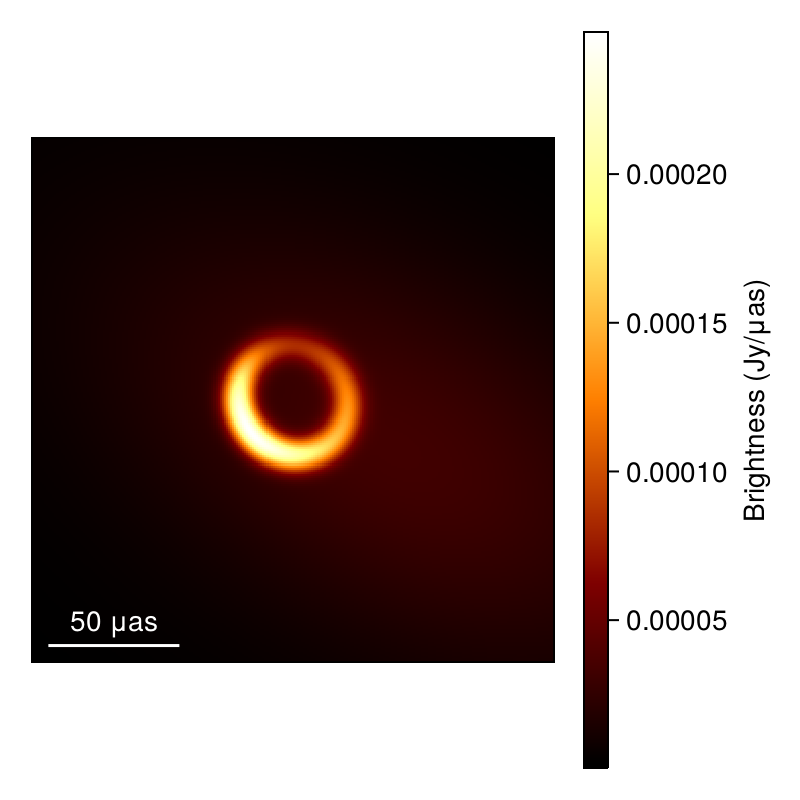

In [30]:
using DisplayAs
import CairoMakie as CM
g = imagepixels(μas2rad(200.0), μas2rad(200.0), 256, 256)
fig = imageviz(intensitymap(model(xopt), g), colormap=:afmhot, size=(400, 400))
DisplayAs.Text(DisplayAs.PNG(fig))

## Quantifying the Uncertainty of the Reconstruction

In [34]:
using Pkg
Pkg.status("Pigeons")

Status `~/astro/Comrade.jl/examples/GeometricModeling_1.8.3/Project.toml`
  [0eb8d820] Pigeons v0.3.0


In [35]:
# Julia 1.8.3 버전에서 발생하는 에러 
# Pigeons 패키지의 버전 문제일거라 생각했지만 
# Pigeons v0.2.0 에서도 v0.3.0 에서도 동일 에러 발생

using Pigeons
pt = pigeons(target = cpost, 
            explorer = SliceSampler(), 
            record = [traces, round_trip, log_sum_ratio], 
            n_chains = 10, 
            n_rounds = 7,
            multithreaded = false)


LoadError: Attempted to call an abstract function.

In [ ]:
chain = sample_array(cpost, pt);

In [ ]:
imgs = intensitymap.(skymodel.(Ref(post), 
                    sample(chain, 100)), 
                    μas2rad(200.0), 
                    μas2rad(200.0), 
                    128, 
                    128)
fig = imageviz(imgs[end], colormap=:afmhot)
DisplayAs.Text(DisplayAs.PNG(fig))

In [ ]:
meanimg = mean(imgs)
fig = imageviz(meanimg, colormap=:afmhot)
DisplayAs.Text(DisplayAs.PNG(fig))

In [ ]:
using Plots
p = Plots.plot(model(xopt), dlcamp, label="MAP")
DisplayAs.Text(DisplayAs.PNG(p))

In [ ]:
p1 = Plots.plot(dlcamp);
p2 = Plots.plot(dcphase);
uva = [sqrt.(uvarea(dlcamp[i])) for i in 1:length(dlcamp)]
uvp = [sqrt.(uvarea(dcphase[i])) for i in 1:length(dcphase)]
for i in 1:10
    mobs = simulate_observation(post, sample(chain, 1)[1])
    mlca = mobs[1]
    mcp  = mobs[2]
    Plots.scatter!(p1, uva, mlca[:measurement], color=:grey, label=:none, alpha=0.1)
    Plots.scatter!(p2, uvp, atan.(sin.(mcp[:measurement]), cos.(mcp[:measurement])), color=:grey, label=:none, alpha=0.1)
end
p = plot(p1, p2, layout=(2,1))
DisplayAs.Text(DisplayAs.PNG(p))

In [ ]:
p1 = residual(model(chain[end]), dlcamp)
p2 = residual(model(chain[end]), dcphase)
p = plot(p1, p2, layout=(2,1))
DisplayAs.Text(DisplayAs.PNG(p))